###1: Setup & Relay Configuration

In [ ]:
# ==============================================================================
# 🏃‍♂️ CRACKATHON RELAY RACE: SETUP
# ==============================================================================
!pip install ultralytics -q
import os
import shutil
import yaml
import torch
import math
from ultralytics import YOLO
from google.colab import drive

# 1. Mount Drive (Data Safety)
drive.mount('/content/drive')

# ======================================================
#  MANUALLY UPDATE THIS NUMBER FOR EACH RELAY
# Leg 1: Fresh Start
# Leg 2: Continues from Leg 1 result...
# ======================================================
LEG_NUMBER = 11
# ======================================================

# 2. Define Paths
# We save models to Drive so they survive the "Relay Handoff"
PROJECT_ROOT = '/content/drive/MyDrive/Crackathon/01_models'
DATASET_ROOT = '/content/dataset'

# 3. Hardware Check
print(f" Hardware: {torch.cuda.get_device_name(0)}")
gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"   VRAM: {gpu_mem:.2f} GB")

if gpu_mem < 14 and LEG_NUMBER == 1:
    print(" WARNING: T4 GPU has ~15GB. img=1024 + batch=8 is tight.")
    print("   If you get CUDA OOM errors, reduce batch to 4 in Cell 4.")

Mounted at /content/drive
 Hardware: Tesla T4
   VRAM: 15.83 GB


###2: Robust Data Loader (The 11GB Handler)

In [ ]:
# --- CELL 2: DATA RELOADER ---
import kagglehub
import time

# Check if data exists locally (Colab wipes this on disconnect)
if os.path.exists(f"{DATASET_ROOT}/train/images"):
    print(" Data found locally. Ready to train.")
else:
    print(f" New Session (Leg {LEG_NUMBER}). Loading Data...")

    # 1. Download to Cache
    cache_path = kagglehub.dataset_download("anulayakhare/crackathon-data")

    # 2. Copy to Workspace (cp -rf is fastest for 11GB)
    print(" Copying 11GB to workspace... (Wait ~3-5 mins)")
    if os.path.exists(DATASET_ROOT): shutil.rmtree(DATASET_ROOT)

    start = time.time()
    # Force copy (recursive, force)
    os.system(f"cp -rf '{cache_path}' '{DATASET_ROOT}'")

    # 3. Fix Nesting (Safety Check)
    if 'train' not in os.listdir(DATASET_ROOT):
        # Look for nested folder
        subs = [x for x in os.listdir(DATASET_ROOT) if os.path.isdir(os.path.join(DATASET_ROOT, x))]
        if subs:
            sub = subs[0]
            print(f"   Fixing nested folder '{sub}'...")
            os.system(f"mv '{DATASET_ROOT}/{sub}'/* '{DATASET_ROOT}'/")
            os.rmdir(f"{DATASET_ROOT}/{sub}")

    print(f" Data Ready in {(time.time() - start)/60:.1f} mins.")

# 4. Re-Generate Config (Ensure it exists)
yaml_content = {
    'path': DATASET_ROOT,
    'train': 'train/images',
    'val': 'val/images',
    'names': {0: 'Longitudinal Crack', 1: 'Transverse Crack', 2: 'Alligator Crack', 3: 'Other Corruption', 4: 'Pothole'}
}
with open('/content/data.yaml', 'w') as f: yaml.dump(yaml_content, f)

 New Session (Leg 11). Loading Data...
Using Colab cache for faster access to the 'crackathon-data' dataset.
 Copying 11GB to workspace... (Wait ~3-5 mins)
   Fixing nested folder 'randomized_dataset'...
 Data Ready in 6.2 mins.


###3: LR Finder (Active ONLY on Leg 1)

In [ ]:
# --- CELL 3: LR STRATEGY (HYBRID: RELAY -> CONTINUOUS) ---
BASE_LR = 0.01

if LEG_NUMBER <= 5:
    # --- PHASE 1: THE RELAY RACE (Finished) ---
    # We kept LR high (0.01) for Legs 1-4, then decayed for Leg 5.
    if LEG_NUMBER <= 4:
        SUGGESTED_LR = 0.01
    else:
        # Leg 5 was the first decay (0.005)
        SUGGESTED_LR = 0.005

    print(f" LEG {LEG_NUMBER} (RELAY PHASE): Suggested LR is {SUGGESTED_LR}")

elif LEG_NUMBER == 6:
    # --- PHASE 2: THE BRIDGE (Restarting Momentum) ---
    # We are starting a NEW continuous run, so we reset LR back to High Energy.
    SUGGESTED_LR = 0.01

    print(f" LEG 6 (THE BRIDGE): RESTARTING MOMENTUM.")
    print(f"    ACTION: Resetting LR to {SUGGESTED_LR} to kickstart the continuous run.")

else:
    # --- PHASE 3: CONTINUOUS RESUME (Leg 7, 8, 9...) ---
    # When using resume=True, YOLO IGNORES this value and loads it from the file.
    SUGGESTED_LR = "AUTOMATIC (Resume Mode)"

    print(f" LEG {LEG_NUMBER} (CONTINUOUS MODE):")
    print(f"    ACTION: LR is managed automatically by 'resume=True'.")
    print(f"   (The model remembers the LR schedule from Leg 6).")

print(f" TARGET LR FOR THIS RUN: {SUGGESTED_LR}")

###4: The Relay Race Training Engine

In [ ]:
# --- CELL 4A: RELAY RACE (ARCHIVE - USED FOR LEGS 1-5) ---
# This code ran 6-epoch sprints and reset momentum each time.
# It kept Mosaic ON (close_mosaic=0) to maximize feature learning.

# --- CONFIGURATION ---
IMG_SIZE = 1024
BATCH_SIZE = 8
NBS = 16
EPOCHS_PER_LEG = 6

# Define Run Names
current_run_name = f"Run_HighRes_Leg{LEG_NUMBER}"
prev_run_name = f"Run_HighRes_Leg{LEG_NUMBER - 1}"

# 1. WEIGHT LOADING LOGIC
if LEG_NUMBER == 1:
    print(" STARTING LEG 1: Loading Standard YOLOv8m...")
    model = YOLO('yolov8m.pt')
else:
    prev_ckpt = f"{PROJECT_ROOT}/{prev_run_name}/weights/best.pt"
    if os.path.exists(prev_ckpt):
        print(f" RELAY HANDOFF: Loading {prev_run_name}")
        model = YOLO(prev_ckpt)
    else:
        print(f" CRITICAL: Could not find '{prev_run_name}'!")
        model = YOLO('yolov8m.pt')

# 2. TRAIN
print(f" LAUNCHING LEG {LEG_NUMBER} (Relay Mode)")
results = model.train(
    data='/content/data.yaml',
    project=PROJECT_ROOT,
    name=current_run_name,
    epochs=EPOCHS_PER_LEG,
    patience=8,
    save_period=1,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    nbs=NBS,
    lr0=SUGGESTED_LR,
    lrf=0.1,
    warmup_epochs=1.0,
    cos_lr=True,

    # RELAY SETTINGS: Keep Mosaic ON
    mosaic=1.0,
    mixup=0.15,
    copy_paste=0.3,
    close_mosaic=0,  # Intentional: Keep Mosaic ON for Legs 1-5

    device=0,
    exist_ok=True,
    resume=False,
    verbose=True
)
print(" Leg Complete.")

 TRAINING LEG 5
    ACTION: Heavy Augmentation Active (Learning Phase).
 RELAY HANDOFF SUCCESSFUL! Loading: Run_HighRes_Leg4
 LAUNCHING LEG 5 (Epochs: 6)
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=6, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=/content/drive/MyDrive/Crackathon/01_models/Run_HighRes_Leg4/wei

In [ ]:
# --- CELL 4B: THE BRIDGE (LEG 6 ONLY - WITH REPORTING) ---
from ultralytics.utils import callbacks
import os
import shutil

# --- CONFIGURATION ---
PREV_LEG_FOLDER = 'Run_HighRes_Leg5'
NEW_RUN_NAME = 'Run_Continuous_Final'
IMG_SIZE = 1024
BATCH_SIZE = 8
NBS = 16

TOTAL_PLAN_EPOCHS = 36
EPOCHS_TO_RUN_NOW = 6

# --- ARCHIVE FUNCTION ---
def archive_reports(run_path, leg_num):
    # Create a sub-folder for this leg's specific graphs
    report_dir = f"{run_path}/Report_Leg{leg_num}"
    os.makedirs(report_dir, exist_ok=True)

    print(f" Archiving graphs to: {report_dir}")

    # List of files to save (snapshot)
    files_to_save = ['results.png', 'confusion_matrix.png', 'results.csv', 'train_batch0.jpg']

    for f in files_to_save:
        src = f"{run_path}/{f}"
        dst = f"{report_dir}/{f}"
        if os.path.exists(src):
            shutil.copy(src, dst)

# --- STOPPER CALLBACK ---
def stop_after_6_epochs(trainer):
    if trainer.epoch + 1 >= EPOCHS_TO_RUN_NOW:
        print(f"\n LEG 6 COMPLETE (Epoch {trainer.epoch + 1})")

        # 1. Archive the graphs immediately
        archive_reports(trainer.save_dir, 6)

        # 2. Save Model & Pause
        print("   Pausing training to preserve Optimizer State...")
        trainer.stop = True
        trainer.save_model()

# 1. Load Leg 5 Weights
prev_ckpt = f"{PROJECT_ROOT}/{PREV_LEG_FOLDER}/weights/best.pt"
if not os.path.exists(prev_ckpt):
    raise FileNotFoundError("Leg 5 Weights missing!")

print(f" STARTING CONTINUOUS RUN (Leg 6)")
model = YOLO(prev_ckpt)
model.add_callback("on_train_epoch_end", stop_after_6_epochs)

model.train(
    data='/content/data.yaml',
    project=PROJECT_ROOT,
    name=NEW_RUN_NAME,
    epochs=TOTAL_PLAN_EPOCHS,
    patience=0, save_period=1,
    lr0=0.01, lrf=0.01, cos_lr=True,
    imgsz=IMG_SIZE, batch=BATCH_SIZE, nbs=NBS,
    mosaic=1.0, mixup=0.15, copy_paste=0.3,
    close_mosaic=12,  # Auto-off for last 12 epochs
    device=0, exist_ok=True, verbose=True
)
print(" Leg 6 Finished. Graphs saved in 'Report_Leg6'.")

 STARTING CONTINUOUS RUN (Leg 6)
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=12, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=36, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=/content/drive/MyDrive/Crackathon/01_models/Run_HighRes_Leg5/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Run_Continuous_Final, nbs=16, nms=False, opset=None, 

In [ ]:
# --- CELL 4C: ROBUST RESUME (SAVES EVERY GRAPH & IMAGE) ---
from ultralytics.utils import callbacks
import os
import glob
import shutil

# --- CONFIGURATION ---
RUN_NAME = 'Run_Continuous_Final'
RUN_DIR = f"{PROJECT_ROOT}/{RUN_NAME}"
EPOCHS_PER_LEG = 6
TARGET_STOP_EPOCH = (LEG_NUMBER - 5) * EPOCHS_PER_LEG

print(f" LEG {LEG_NUMBER} GOAL: Stop at Epoch {TARGET_STOP_EPOCH}")

# --- HELPER: FIND LATEST HEAVY WEIGHTS ---
def get_latest_heavy_checkpoint(folder):
    files = glob.glob(f"{folder}/weights/*.pt")
    if not files: return None
    files.sort(key=os.path.getmtime, reverse=True)
    for f in files:
        if os.path.getsize(f) / (1024 * 1024) > 70:
            return f
    return None

# --- HELPER: CLEANUP OLD EPOCHS ---
def cleanup_old_epochs(folder, current_epoch):
    files = glob.glob(f"{folder}/weights/epoch*.pt")
    for f in files:
        try:
            filename = os.path.basename(f)
            e_num = int(filename.replace("epoch", "").replace(".pt", ""))
            if e_num < current_epoch:
                print(f" Cleaning up old checkpoint: {filename}")
                os.remove(f)
        except: pass

# --- UPDATED ARCHIVE FUNCTION (UNIVERSAL) ---
def archive_reports(run_path, leg_num):
    report_dir = f"{run_path}/Report_Leg{leg_num}"
    os.makedirs(report_dir, exist_ok=True)

    print(f" Archiving ALL graphs/images to: {report_dir}")

    # 1. GRAB ALL PNGs (Curves, Confusion Matrices, Results)
    pngs = glob.glob(f"{run_path}/*.png")

    # 2. GRAB ALL JPGs (Train Batches, Validation Batches, Labels)
    jpgs = glob.glob(f"{run_path}/*.jpg")

    # 3. GRAB RESULTS CSV
    csvs = glob.glob(f"{run_path}/*.csv")

    # 4. COPY THEM ALL
    all_files = pngs + jpgs + csvs

    for src in all_files:
        filename = os.path.basename(src)
        dst = f"{report_dir}/{filename}"
        shutil.copy(src, dst)
        # print(f"   Saved: {filename}") # Uncomment if you want a long list printed

# --- STOPPER CALLBACK ---
def stop_at_target(trainer):
    if trainer.epoch + 1 >= TARGET_STOP_EPOCH:
        print(f"\n LEG {LEG_NUMBER} COMPLETE (Epoch {trainer.epoch + 1})")

        # 1. Archive EVERYTHING
        archive_reports(trainer.save_dir, LEG_NUMBER)

        # 2. Cleanup Old Weights
        cleanup_old_epochs(trainer.save_dir, trainer.epoch)

        # 3. Pause
        print(f" Safe Checkpoint 'epoch{trainer.epoch}.pt' preserved.")
        print("   Pausing training...")
        trainer.stop = True

# --- MAIN EXECUTION ---
resume_file = get_latest_heavy_checkpoint(RUN_DIR)

if resume_file:
    print(f" FOUND HEAVY CHECKPOINT: {os.path.basename(resume_file)}")
    print(f"   Size: {os.path.getsize(resume_file)/1e6:.1f} MB (Optimizer Detected )")

    model = YOLO(resume_file)
    model.add_callback("on_train_epoch_end", stop_at_target)

    model.train(
        resume=True,
        save_period=1,
        project=PROJECT_ROOT,
        name=RUN_NAME
    )
    print(f" Leg {LEG_NUMBER} Finished Successfully.")

else:
    print(f" CRITICAL ERROR: No heavy checkpoint (>70MB) found in {RUN_DIR}")

 LEG 11 GOAL: Stop at Epoch 36
 FOUND HEAVY CHECKPOINT: epoch29.pt
   Size: 103.9 MB (Optimizer Detected ✅)
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=12, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=36, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=/content/drive/MyDrive/Crackathon/01_models/Run_Continuous_Final/weights/epoch29.pt, momentum=0.937, mosaic=

###5: Final Validation (The "Champion" Check)


🚀 STARTING 'ULTIMATE' VALIDATION: Run_Continuous_Final
   Model: best.pt
   Strategy: High-Res (1280px) + TTA (Test Time Augmentation)
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1886.4±731.9 MB/s, size: 331.8 KB)
val: Scanning /content/dataset/val/labels.cache... 6000 images, 1792 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6000/6000 9.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1500/1500 1.1it/s 22:18
                   all       6000      10443      0.583      0.559      0.573      0.303
    Longitudinal Crack       2171       4093      0.572      0.583      0.584      0.327
      Transverse Crack       1209       1830       0.56      0.549      0.551      0.263
       Alligator Crack       1353       1698      0.626      0.559      0.598   

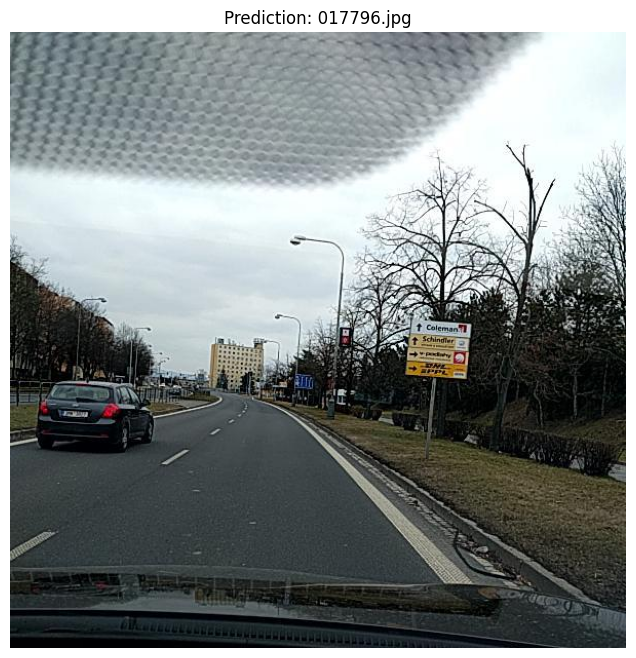

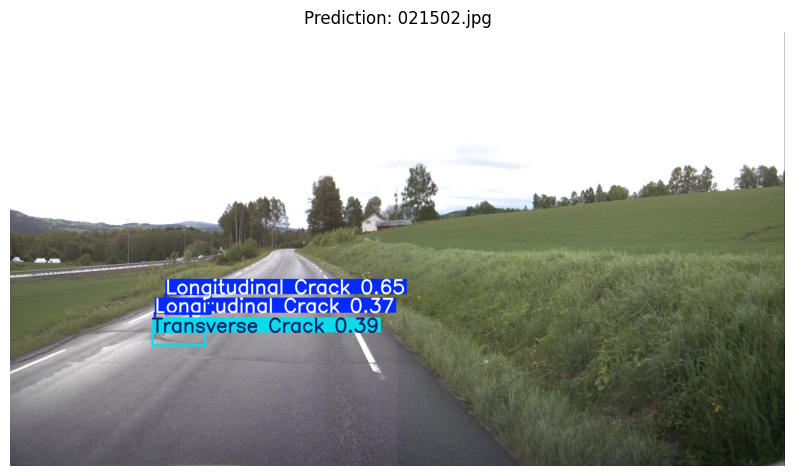

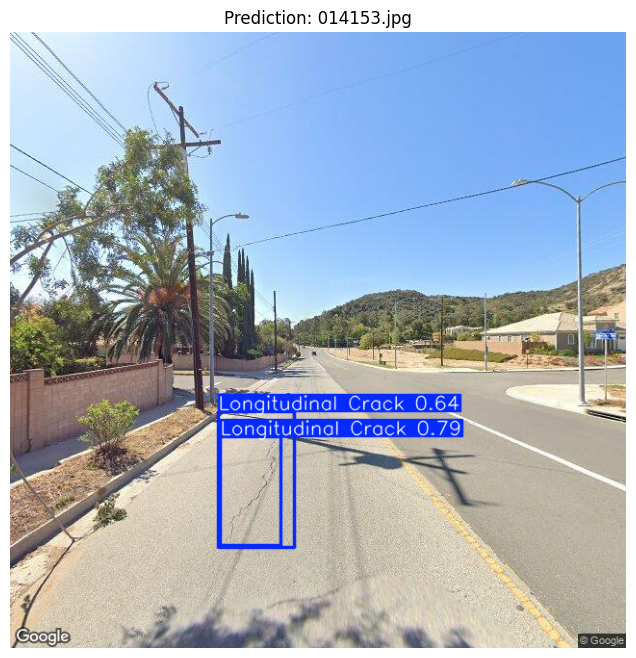

In [ ]:
import glob
import matplotlib.pyplot as plt
import cv2
import random
from ultralytics import YOLO
import os

# --- CONFIGURATION ---
RUN_NAME = 'Run_Continuous_Final'
PROJECT_ROOT = '/content/drive/MyDrive/Crackathon/01_models'
BEST_MODEL = f"{PROJECT_ROOT}/{RUN_NAME}/weights/best.pt"

if os.path.exists(BEST_MODEL):
    print(f"\n STARTING 'ULTIMATE' VALIDATION: {RUN_NAME}")
    print(f"   Model: {os.path.basename(BEST_MODEL)}")
    print("   Strategy: High-Res (1280px) + TTA (Test Time Augmentation)")

    # 1. Load the Champion
    val_model = YOLO(BEST_MODEL)

    # 2. Run Validation
    # (If you JUST ran this and 'metrics' is still in memory, you can comment this block out to save time)
    metrics = val_model.val(
        data='/content/data.yaml',
        split='val',
        imgsz=1280,
        batch=4,
        augment=True,
        project=f"{PROJECT_ROOT}/{RUN_NAME}",
        name='Final_Ultimate_Result',
        plots=True
    )

    print("\n" + "="*50)
    print(f" OFFICIAL FINAL SCORE:")
    print(f"   mAP@50        : {metrics.box.map50:.4f}")
    print(f"   mAP@50-95     : {metrics.box.map:.4f}")

    # --- CRITICAL FIX: DYNAMIC POTHOLE SEARCH ---
    # This finds the 'Pothole' class automatically, no matter what index it is.
    pothole_indices = [k for k, v in val_model.names.items() if 'Pothole' in v]

    if pothole_indices:
        idx = pothole_indices[0] # Get the ID (e.g., 4)
        pothole_score = metrics.box.maps[idx] # Get the specific mAP50-95
        print(f"   Pothole mAP   : {pothole_score:.4f} (High Precision)")
    else:
        print(" 'Pothole' class not found in model names.")

    print("="*50 + "\n")

    # 3. Visualize a few "High Res" Predictions
    print(" Visualizing Predictions...")
    val_images = glob.glob("/content/dataset/val/images/*.jpg")
    if val_images:
        random_samples = random.sample(val_images, 3)
        results = val_model.predict(random_samples, imgsz=1280, augment=True)

        for res in results:
            res_plotted = res.plot()
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Prediction: {os.path.basename(res.path)}")
            plt.show()

else:
    print(f" ERROR: Could not find model at {BEST_MODEL}")

###6: Generating Graphs for report

In [ ]:
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# === CONFIGURATION ===
PROJECT_ROOT = '/content/drive/MyDrive/Crackathon'
MODEL_PATH = f"{PROJECT_ROOT}/01_models/Run_Continuous_Final/weights/best.pt"
OUTPUT_DIR = f"{PROJECT_ROOT}/03_reports/assets3"
VAL_IMG_DIR = '/content/dataset/val/images'
VAL_LABEL_DIR = '/content/dataset/val/labels'

CLASS_NAMES = {
    0: 'Longitudinal Crack',
    1: 'Transverse Crack',
    2: 'Alligator Crack',
    3: 'Other Corruption',
    4: 'Pothole'
}

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f" Generating 3 Sets of Batch Grids (Total 6 files)...")
print(f" Saving to: {OUTPUT_DIR}")

model = YOLO(MODEL_PATH)

# --- HELPER: DRAW ACTUAL LABELS ---
def draw_actual(img_path, label_dir):
    img = cv2.imread(img_path)
    if img is None: return None
    h, w, _ = img.shape

    basename = os.path.basename(img_path)
    label_path = os.path.join(label_dir, basename.replace('.jpg', '.txt'))

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            cls_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])

            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)

            name = CLASS_NAMES.get(cls_id, str(cls_id))

            # Green Box & Label
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5)
            # Text Background for readability
            (tw, th), _ = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 3)
            cv2.rectangle(img, (x1, y1 - 40), (x1 + tw, y1), (0, 255, 0), -1)
            # Text
            cv2.putText(img, name, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    else:
        # If no labels, write "Background"
        cv2.putText(img, "No Objects", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- HELPER: DRAW PREDICTIONS ---
def draw_pred(model, img_path):
    # Predict and plot
    res = model.predict(img_path, imgsz=1024, conf=0.25, verbose=False)[0]
    plot_bgr = res.plot(line_width=5, font_size=1.5)
    return cv2.cvtColor(plot_bgr, cv2.COLOR_BGR2RGB)

# --- MAIN: CREATE THE 2x2 GRIDS ---
def create_paired_batch_sets(set_id, image_paths):
    # 1. Create ACTUAL Grid
    plt.figure(figsize=(20, 20))
    for i, img_path in enumerate(image_paths):
        plt.subplot(2, 2, i + 1)
        img = draw_actual(img_path, VAL_LABEL_DIR)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Actual: {os.path.basename(img_path)}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    save_actual = f"{OUTPUT_DIR}/Set{set_id}_Batch_ACTUAL.jpg"
    plt.savefig(save_actual, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✅ Set {set_id}: Saved ACTUAL grid.")

    # 2. Create PREDICTED Grid (Same Images)
    plt.figure(figsize=(20, 20))
    for i, img_path in enumerate(image_paths):
        plt.subplot(2, 2, i + 1)
        img = draw_pred(model, img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {os.path.basename(img_path)}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    save_pred = f"{OUTPUT_DIR}/Set{set_id}_Batch_PREDICTED.jpg"
    plt.savefig(save_pred, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✅ Set {set_id}: Saved PREDICTED grid.")

# === EXECUTION ===
all_imgs = glob.glob(f"{VAL_IMG_DIR}/*.jpg")
random.shuffle(all_imgs)

# Generate 3 Sets
for set_num in range(1, 4):
    start = (set_num - 1) * 4
    end = set_num * 4

    if end > len(all_imgs):
        print("Not enough images left for another set.")
        break

    batch_of_4 = all_imgs[start:end]
    print(f"\nGenerating Set {set_num} (Images: {len(batch_of_4)})...")
    create_paired_batch_sets(set_num, batch_of_4)

print(f"\n🎉 DONE! 6 files (3 Actual + 3 Predicted) saved to {OUTPUT_DIR}")

🚀 Generating 3 Sets of Batch Grids (Total 6 files)...
📂 Saving to: /content/drive/MyDrive/Crackathon/03_reports/assets3

Generating Set 1 (Images: 4)...
✅ Set 1: Saved ACTUAL grid.
✅ Set 1: Saved PREDICTED grid.

Generating Set 2 (Images: 4)...
✅ Set 2: Saved ACTUAL grid.
✅ Set 2: Saved PREDICTED grid.

Generating Set 3 (Images: 4)...
✅ Set 3: Saved ACTUAL grid.
✅ Set 3: Saved PREDICTED grid.

🎉 DONE! 6 files (3 Actual + 3 Predicted) saved to /content/drive/MyDrive/Crackathon/03_reports/assets3


In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import os

# --- CONFIGURATION ---
TRAIN_IMG_DIR = '/content/dataset/train/images'
TRAIN_LABEL_DIR = '/content/dataset/train/labels'
# The location you requested
OUTPUT_DIR = '/content/drive/MyDrive/Crackathon/03_reports/assets2'

os.makedirs(OUTPUT_DIR, exist_ok=True)

CLASS_NAMES = {
    0: 'Longitudinal Crack',
    1: 'Transverse Crack',
    2: 'Alligator Crack',
    3: 'Other Corruption',
    4: 'Pothole'
}

def save_ground_truth_samples(num_samples=3):
    # 1. Get images
    all_img_paths = glob.glob(f"{TRAIN_IMG_DIR}/*.jpg")
    if not all_img_paths:
        print(" Error: No training images found.")
        return

    # 2. Select Random Samples
    selected_files = random.sample(all_img_paths, num_samples)

    # 3. Create High-Res Figure
    plt.figure(figsize=(24, 8)) # Wide layout for 3 images

    for i, img_path in enumerate(selected_files):
        img = cv2.imread(img_path)
        if img is None: continue

        # Draw Boxes
        h, w, _ = img.shape
        basename = os.path.basename(img_path)
        label_path = os.path.join(TRAIN_LABEL_DIR, basename.replace('.jpg', '.txt'))

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                cls_id = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])

                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)

                # Draw Green Box (Ground Truth)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4)

                # Add Label
                label_text = CLASS_NAMES.get(cls_id, str(cls_id))
                cv2.putText(img, label_text, (x1, y1 - 15),
                           cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

        # Convert to RGB and Plot
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Train Sample: {basename}", fontsize=14, fontweight='bold')

    # 4. Save to the path
    save_path = f"{OUTPUT_DIR}/Data_Sanity_GroundTruth.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close() # Close to free memory
    print(f" Saved Ground Truth Check to: {save_path}")

# Run it
save_ground_truth_samples()

 Saved Ground Truth Check to: /content/drive/MyDrive/Crackathon/03_reports/assets2/Data_Sanity_GroundTruth.png


In [ ]:
import os
import glob
import shutil
import zipfile
from ultralytics import YOLO

# ==========================================
# ⚙️ CONFIGURATION (Verify these paths!)
# ==========================================
PROJECT_ROOT = '/content/drive/MyDrive/Crackathon'
MODEL_PATH = f"{PROJECT_ROOT}/01_models/Run_Continuous_Final/weights/best.pt"
TEST_IMG_DIR = '/content/dataset/test/images'
SUBMISSION_DIR = f"{PROJECT_ROOT}/02_submissions"
PRED_DIR = f"{SUBMISSION_DIR}/predictions"
FINAL_ZIP_PATH = f"{SUBMISSION_DIR}/submission.zip"

# ==========================================
# 1. SETUP & CLEANUP
# ==========================================
print(" STARTING FINAL SUBMISSION PIPELINE")

# Create submission folder if missing
os.makedirs(SUBMISSION_DIR, exist_ok=True)

# Clean previous predictions to ensure no old files remain
if os.path.exists(PRED_DIR): shutil.rmtree(PRED_DIR)
os.makedirs(PRED_DIR, exist_ok=True)

# Delete old zip if it exists
if os.path.exists(FINAL_ZIP_PATH): os.remove(FINAL_ZIP_PATH)

# ==========================================
# 2. RUN INFERENCE (1280px + TTA)
# ==========================================
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model not found at: {MODEL_PATH}")

print(f"   Model:      {os.path.basename(MODEL_PATH)}")
print(f"   Resolution: 1280px (Champion Setting)")
print(f"   TTA Mode:   Enabled (Test Time Augmentation)")

model = YOLO(MODEL_PATH)
test_files = glob.glob(f"{TEST_IMG_DIR}/*.jpg")

if not test_files:
    raise FileNotFoundError(" No images found in Test Folder!")

print(f"   Processing {len(test_files)} images... (This takes ~20-40 mins)")

# Run Prediction
results = model.predict(
    source=TEST_IMG_DIR,
    conf=0.25,      # Standard competition threshold
    imgsz=1280,     # <--- WINNING RESOLUTION
    augment=True,   # <--- TTA ENABLED
    stream=True,    # Stream prevents RAM crash
    verbose=False
)

count = 0
sample_file = None

for res in results:
    filename = os.path.basename(res.path)
    txt_name = filename.replace('.jpg', '.txt')
    save_path = os.path.join(PRED_DIR, txt_name)

    with open(save_path, 'w') as f:
        for box in res.boxes:
            # EXTRACT DATA
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])

            # NORMALIZED COORDINATES [x, y, w, h] (0.0 - 1.0)
            x, y, w, h = box.xywhn[0].tolist()

            # Write: class x y w h conf
            line = f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f} {conf:.6f}\n"
            f.write(line)

    # Save one file path for the audit later
    if count == 0: sample_file = save_path

    count += 1
    if count % 100 == 0: print(f"   Processed {count}...", end='\r')

print(f"\n Prediction Complete. Generated {count} text files.")

# ==========================================
# 3. DATA AUDIT (Logic Check)
# ==========================================
print("\n🔍 AUDITING DATA (Logic Check)...")
if sample_file and os.path.exists(sample_file):
    with open(sample_file, 'r') as f:
        content = f.read().strip()
        if content:
            first_line = content.split('\n')[0]
            print(f"   Sample Data: {first_line}")
            parts = first_line.split()
            x_check = float(parts[1])

            if x_check > 1.0:
                print(" CRITICAL FAILURE: Coordinates are > 1.0 (Pixel values).")
                print("   ABORTING ZIP TO PROTECT SUBMISSION.")
                exit()
            else:
                print(" PASSED: Coordinates are Normalized (0.0 - 1.0).")
        else:
            print(" Sample file was empty (no damage detected). Logic check skipped for this file.")
else:
    print(" No predictions generated? (Check if model loaded correctly)")

# ==========================================
# 4. ZIP CREATION (Manual & Strict)
# ==========================================
print(f"\n Zipping {count} files into 'submission.zip'...")

txt_files = glob.glob(f"{PRED_DIR}/*.txt")

if not txt_files:
    print(" ERROR: No text files found to zip!")
else:
    with zipfile.ZipFile(FINAL_ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as z:
        for file_path in txt_files:
            filename = os.path.basename(file_path)
            # FORCE internal folder structure: 'predictions/filename.txt'
            z.write(file_path, arcname=f"predictions/{filename}")

    print(f" Zip Created Successfully: {FINAL_ZIP_PATH}")

    # ==========================================
    # 5. FINAL ZIP VERIFICATION
    # ==========================================
    print("\n VERIFYING ZIP STRUCTURE...")
    with zipfile.ZipFile(FINAL_ZIP_PATH, 'r') as z:
        file_list = z.namelist()
        first_file = file_list[0]
        count_in_zip = len([f for f in file_list if f.endswith('.txt')])

        print(f"   First file inside: {first_file}")
        print(f"   Total files inside: {count_in_zip}")

        if first_file.startswith("predictions/") and count_in_zip == len(txt_files):
            print("\n SUCCESS! The submission file is PERFECT.")
            print(f"   DOWNLOAD HERE: {FINAL_ZIP_PATH}")
        else:
            print(" ZIP STRUCTURE ERROR. Something went wrong.")

 STARTING FINAL SUBMISSION PIPELINE
   Model:      best.pt
   Resolution: 1280px (Champion Setting)
   TTA Mode:   Enabled (Test Time Augmentation)
   Processing 6000 images... (This takes ~20-40 mins)
   Processed 6000...
 Prediction Complete. Generated 6000 text files.

🔍 AUDITING DATA (Logic Check)...
 Sample file was empty (no damage detected). Logic check skipped for this file.

 Zipping 6000 files into 'submission.zip'...
 Zip Created Successfully: /content/drive/MyDrive/Crackathon/02_submissions/submission.zip

 VERIFYING ZIP STRUCTURE...
   First file inside: predictions/000004.txt
   Total files inside: 6000

 SUCCESS! The submission file is PERFECT.
   DOWNLOAD HERE: /content/drive/MyDrive/Crackathon/02_submissions/submission.zip
